# Lab 8: Spectral Factorizations

In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt
import os
import copy
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## Part 1. Learning Spectral Components

In this part we will design a simple component analyzer. Use the sound file [https://drive.google.com/uc?export=download&id=1fyHhUqYVOrIPzSMJoQC78sqeokjqI4ib]. This is a drum loop with four distinct sounds (bass drum, snare drum, cymbal and synthetic bell sound). We will use a spectral factorization that will allow us to extract them all. Obtain the STFT of this signal and use a DFT size of 4096, a hop size of 256 and a Hann window. This will be stored in a matrix $\mathbf F$ whose size will be $M$ by $N$. 

You now need to implement a factorization technique. This is defined as:

$$|\mathbf F | \approx \mathbf{W} \cdot \mathbf{H}$$
$$\mathbf{F} \in \mathbb{R}^{M\times N}_+, \mathbf{W} \in \mathbb{R}^{M\times K}_+, \mathbf{H} \in \mathbb{R}^{K\times N}_+$$

Where $\mathbb{R}^{A\times B}_+$ is the set of matrices of size $A \times B$ containing non-negative elements, and $|\mathbf{F}|$ takes the absolute value of the STFT matrix $\mathbf{F}$.  In this case we will use $K$=4 since the mix we are analyzing has four distinct sounds.  To estimate the values of $\mathbf{W}$ and $\mathbf{H}$ start by filling them with uniformly random values between 10 to 11 and iterate over the following equations:

$$\mathbf{V} = \frac{|\mathbf{F}|}{\mathbf{W}\cdot \mathbf{H} + \epsilon}$$
$$\mathbf{H} = \mathbf{H} \odot \left[ \mathbf{W}^\top \cdot \mathbf{V} \right]$$
$$\mathbf{W} = \mathbf{W} \odot \left[ \mathbf{V} \cdot \mathbf{H}^\top \right]$$

Where $\odot$ denotes element-wise multiplication and the fraction performs element-wise division.  The constant $\epsilon$ is assigned to a small value (e.g. 1e-7) to avoid division by zero. After each pass normalize the columns of $\mathbf{W}$ to sum to 1.  Iterate for about 100 times.

Plot the columns of $\mathbf{W}$ and explain what they correspond to. Plot the rows of $\mathbf{H}$ and explain them as well. You might have to run the above procedure a couple of times since in some cases the results can come up wrong. Just to be safe, run this a dozen times and show the results that are representative of the majority of the outputs (note that each time the ordering will be different, we only care about the shapes of these quantities, not their order).

You can now try to extract each component. Take each column of $\mathbf{W}$ and compute its outer product with its corresponding row of $\mathbf{H}$. This will approximate only one component of the input spectrogram. Plot all four products and explain what they look like. Use the phase of the original input to invert these resulting spectrograms to the time domain and listen to them. What do they sound like?

In [2]:
# YOUR CODE HERE
# raise NotImplementedError()
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
def get_stft(x, dft_size=4096, hop_size=256, zero_pad=0, window='hanning'):
    # YOUR CODE HERE
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    L = len(x)
    num_frame = (L-dft_size)//hop_size
    tail = L-(num_frame*hop_size+dft_size)
    if tail>0:
        pad = hop_size-tail
        x = np.pad(x, (0,pad), 'constant')
        num_frame += 1
    stft = np.zeros((num_frame, int((dft_size+zero_pad)/2)+1)).astype(complex)
    for i, t in enumerate(stft[:]):
        input_f = x[i*hop_size:i*hop_size+dft_size].astype(float)
        input_f *= w(len(input_f))
        input_f = np.pad(input_f, (0, zero_pad), 'constant')    
        stft[i] = np.fft.rfft(input_f)
    stft = stft.T
    # Return padded input sound and a complex-valued spectrogram (frequencies x time)
    return stft

def get_istft(stft, dft_size=4096, hop_size=256, zero_pad=0, window='hanning'):
    # YOUR CODE HERE
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    
    T = stft.shape[1]
    L = hop_size*T+dft_size+zero_pad
    x = np.zeros(L)
    for t in range(T):
        curr_frame = stft[:, t]
        ifft = np.fft.irfft(curr_frame)
        ifft *= w(len(ifft)) * 0.7
        idx = t*hop_size
        x[idx:idx+dft_size+zero_pad] += ifft
    return x

def plot_spectrogram(x, stft, fs, title):
    x = x/ np.max(x)
    t = np.linspace(0, len(x)/fs, stft.shape[1])
    f = np.linspace(0, int(fs/2), stft.shape[0])
    plt.pcolormesh(t, f, abs(stft)**.3)
    plt.title(title.capitalize()+' Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def NMF(F, K=4, steps=100):
    M, N = F.shape
    F_abs = abs(F)
    # randomly initialize W an H
    W = np.random.uniform(low=10, high=11, size=(M, K))
    H = np.random.uniform(low=10, high=11, size=(K, N))
    # iteratively update W and H
    for step in range(steps):
        V = F_abs/(W @ H + 1e-7)
        H *= (W.T @ V)
        W *= (V @ H.T) # add a small number to ensure numerical stability
        W = W/np.sum(W, axis=0)
    return W, H

def plot_components(components, title, ylabel, xlabel):
    plt.figure(figsize=(15,12))
    plt.suptitle(title, size=16)
    prefix = ['1st ','2nd ','3rd ','4th ']
    for i in range(len(components)):
        plot_idx = 410+i+1
        plt.subplot(plot_idx)
        plt.plot(components[i])
        plt.ylabel(prefix[i]+ylabel+' Component')
        plt.xlabel(xlabel)
    plt.show()
    
def reconstruct(W, H, phase):
    C = []
    for i in range(W.shape[1]):
        w = W[:,i].reshape((-1, 1))
        h = H[i,:].reshape((1, -1))
        c_stft = np.matmul(w, h)*np.exp(1j*phase)
        c = get_istft(c_stft)
        C.append(c)
    return C

In [3]:
fname = '80s-hi.wav'
fs, x = read(fname)
stft = get_stft(x)
W, H = NMF(stft)

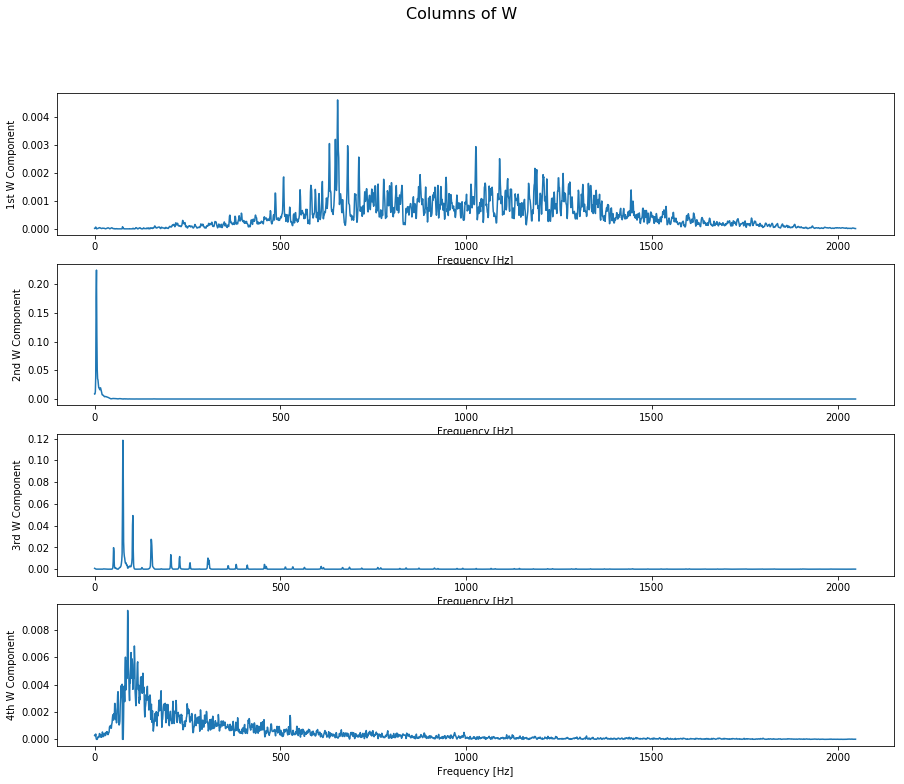

In [4]:
plot_components(W.T, 'Columns of W', 'W', 'Frequency [Hz]')

Each column of $\textbf{W}$ corresponds to each instrument. Following the order of the plots:

$\bullet$ The first column corresponds to the cymbal. The energy of the spectrum spread over frequencies in the middle because the cymbal does not sound too low or too high, while there is some slightly fricative noise as we can expect from a cymbal.

$\bullet$ The second column corresponds to the bass drum. As expected, it only contains a single pulse at a very low frequency.

$\bullet$ The third column corresponds to the synthetic bell. Most of its energy is concentrated at a low pitch, while there are some secondary peaks at frequencies around the impulse.

$\bullet$ The last column corresponds to the snare drum. Like the synthetic bell, the spectrum has a dominant peak at a low frequency. However, there are much more secondary peaks around the center, which decay to both sides of the spectrum. These correspond to the fricative sound effect created by the snare drum.

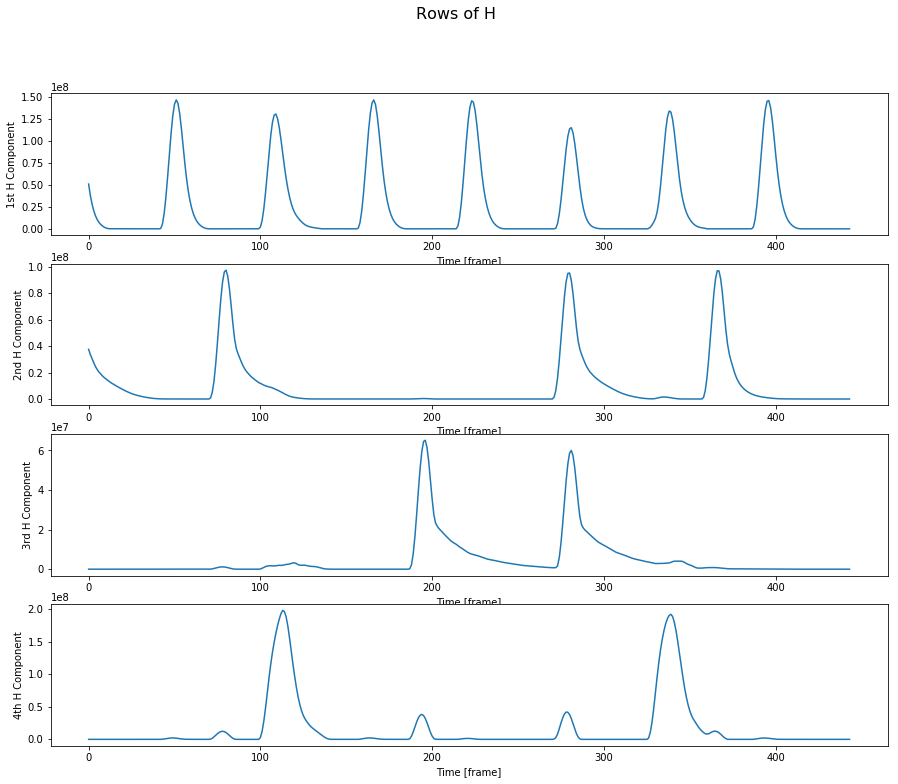

In [5]:
plot_components(H, 'Rows of H', 'H', 'Time [frame]')

Each row of $\textbf{H}$ corresponds to each instrument. Following the order of the plots:

$\bullet$ The first row corresponds to the cymbal. Thy cymbal displays a periodic-like pattern which correspond to the time stamps at which it is hit.

$\bullet$ The second row corresponds to the bass drum. There is a beat at the beginning, and two more at the end, so we see three peaks.

$\bullet$ The third row corresponds to the synthetic bell. There are two noticeale bell sounds we hear along the signal, so there are two peaks in the middle.

$\bullet$ The last row corresponds to the snare drum. The snare drum also display a periodic-like pattern, and each period contains one light hit, one strong hit, and then another light hit again. The pattern we observe matches what we hear.

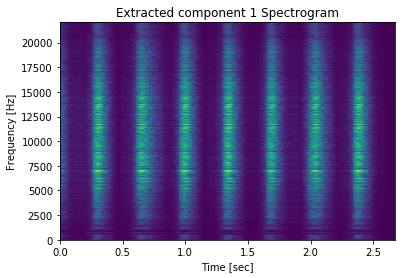

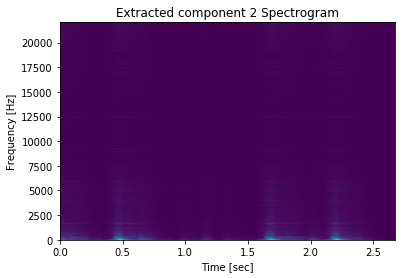

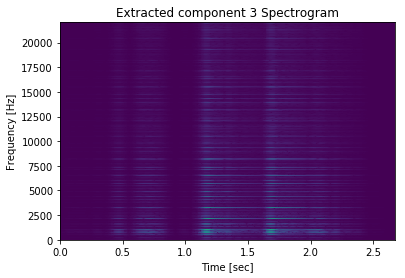

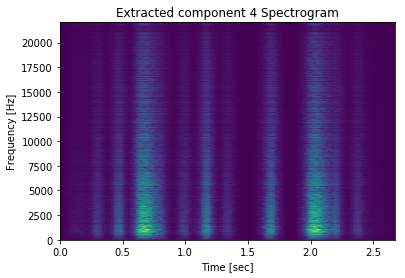

extracted component 1


extracted component 2


extracted component 3


extracted component 4


In [6]:
phase = np.angle(stft)
components = reconstruct(W, H, phase)
for i in range(len(components)):
    stft = get_stft(components[i])
    plot_spectrogram(components[i], stft, fs, 'extracted component '+str(i+1))
for i in range(len(components)):
    sound(components[i], fs, 'extracted component '+str(i+1))

Each spectrogram looks just like the matrix multiplication of the corresponding column and row. The column of $\textbf{W}$ represents how energy is distributed along the frequencies on the spectrogram, while the row of $\textbf{H}$ can be viewed as weights applied to the column of $\textbf{W}$ and determines where they should be present along the time axis. When we reconstruct the components using $\textbf{W}$ and $\textbf{H}$, each component sounds like each instrument played individually.

## Part 2: Trainign Dictionaries for Source Separation

In this section we will design a system that separates speech of a known speaker from a known type of noise. Use the sound files [https://drive.google.com/uc?export=download&id=1fhTSrXDDbsp06oqlrBL9p9JToC4Mws11 ] and [https://drive.google.com/uc?export=download&id=1fmtVWSLp5ZB5_pkFvr8BEXSj0bRuNe70] from the lab archive.

One of them is of speech and the other one of chimes. Take the first sentence of the speech sound and a segment which is just as long from the beginning of the chime sound and add them together. This will be a mixture that we will try to separate. The rest of the data we will use for training dictionary models.
Taking the rest of the speech data run a factorization as we’ve done above with $K$ = 40. Do the same with the remaining chime sound. From these you will obtain two matrices $\mathbf{W}_s$ and $\mathbf{W}_c$. These are the dictionaries of the two sounds. If you visually inspect them you will see that they look a lot like representative spectra of these two sounds.

In order to resolve the mixture we need to use these dictionaries to explain its spectrogram and then only use each dictionary’s contribution to resynthesize a time signal. This essentially involves finding the $\mathbf{H}$ matrix while fixing the $\mathbf{W}$ matrix to be a concatenation of $\mathbf{W}_s$ and $\mathbf{W}_c$. You can do that using the iterative approach used in the previous part, but only updating $\mathbf{H}$ and not updating $\mathbf{W}$ at every iteration. If you do this on the mixture you will ultimately get a $\mathbf{H}$ that will let us know how to combine the elements of the pretrained dictionaries to approximate the input.

To extract the two sounds you need to isolate the contribution of the two dictionaries on the mixture. That will be $\mathbf{F}_s = \mathbf{W}_s \cdot \mathbf{H}_s$ and $\mathbf{F}_c = \mathbf{W}_c \cdot \mathbf{H}_c$, where $\mathbf{H}_s$ corresponds to the first 40 rows of $\mathbf{H}$ and $\mathbf{H}_c$ to its second 40 rows. $\mathbf{F}_s$ and $\mathbf{F}_c$  will correspond to the magnitude spectrograms of the two extracted sources. Just as before use the phase of the input mixture to invert these back to the time domain and listen to them. Do they sound like they are separated? Play around with the STFT parameters until you get the best sounding results.

In [7]:
def NMF_H_only(F, W, K=4, steps=100):
    M, N = F.shape
    F_abs = abs(F)
    # randomly initialize H
    H = np.random.uniform(low=10, high=11, size=(K, N))
    # iteratively update H
    for step in range(steps):
        V = F_abs/(W @ H + 1e-7)
        H *= (W.T @ V)
    return H

In [8]:
# YOUR CODE HERE
# raise NotImplementedError()
fs, s = read('speaker.wav')
fs, c = read('chimes.wav')
x = s[:int(fs*3.5)]+c[:int(fs*3.5)]
sound(x, fs, 'speaker and chimes mixture')

speaker and chimes mixture


In [9]:
stft = get_stft(x, dft_size=1024, hop_size=256)
phase = np.angle(stft)
s_stft = get_stft(s, dft_size=1024, hop_size=256)
c_stft = get_stft(c, dft_size=1024, hop_size=256)
Ws, _ = NMF(s_stft, K=40)
Wc, _ = NMF(c_stft, K=40)
W = np.concatenate((Ws, Wc), axis=1)
H = NMF_H_only(stft, W, K=80)
Hs, Hc = H[:40, :], H[40:, :]
Fs = np.matmul(Ws, Hs)*np.exp(1j*phase)
Fc = np.matmul(Wc, Hc)*np.exp(1j*phase)
s_out = get_istft(Fs, dft_size=1024, hop_size=256)
c_out = get_istft(Fc, dft_size=1024, hop_size=256)
sound(s_out, fs, 'extracted speaker')
sound(c_out, fs, 'extracted chimes')

extracted speaker


extracted chimes


We can hear that each component sounds just like it is separated from the mixture.